<a href="https://colab.research.google.com/github/rehan363/lang_chain/blob/main/2_1_tools_messages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**MESSAGES**

LangChain supports various messages like other llm supports, including HumanMessage, AIMessage,
SystemMessage, and ToolMessage.

Each message can be supplied with a few things:

**content** : *content of the message*

**name** : *optionally, a message author*

**response_metadata** - *optionally, a dict of metadata (e.g., often populated by model provider for AIMessages*)

In [30]:
%%capture --no-stderr
%pip install langgraph , langchain_core

In [31]:
from pprint import pprint
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

message = [AIMessage (content="hello! how can i help you!",name="Model")]
message.append (HumanMessage(content="give me best places  to visit", name= "rehan"))
message.append (AIMessage(content="There are many places to visit uk , usa, etc", name="Model"))

for m in message:
  m.pretty_print()

================================== Ai Message ==================================
Name: Model

hello! how can i help you!
================================ Human Message =================================
Name: rehan

give me best places  to visit
================================== Ai Message ==================================
Name: Model

There are many places to visit uk , usa, etc


In [15]:
#settting up model
from google.colab import userdata
gemini_api_key = userdata.get('GOOGLE_API_KEY')

In [16]:
!pip install --quiet -U langchain-google-genai

In [ ]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model = "gemini-1.5-flash",
    api_key= gemini_api_key,
)

In [17]:
simple_call = llm.invoke("hello")
print(simple_call)

content='Hello there! How can I help you today?\n' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-0f886f54-6aff-45a1-88b5-54d451789bc2-0' usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}}


In [18]:
print(llm )

model='models/gemini-1.5-flash' google_api_key=SecretStr('**********') client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x78470630da20> default_metadata=()


In [19]:
def deposit_money(name: str, bank_account_number: int, amount: int)->dict:
  """deposit money in account
  arguments
  name: account holder name
  bank_account_number: banck account id
  amount: amount to be deposited

  return:
    dict
  """
  return{"status": f"sucessfully! deposit {amount} in {name} account"}


In [20]:
deposit_money(name="rehan", bank_account_number=7377713, amount=10000)

{'status': 'sucessfully! deposit 10000 in rehan account'}

In [21]:
llm_with_tools = llm.bind_tools([deposit_money])

In [22]:
print(llm_with_tools)

bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x78470630da20>, default_metadata=()) kwargs={'tools': [{'type': 'function', 'function': {'name': 'deposit_money', 'description': 'deposit money in account\narguments\nname: account holder name\nbank_account_number: banck account id\namount: amount to be deposited return:\n  dict', 'parameters': {'properties': {'name': {'type': 'string'}, 'bank_account_number': {'type': 'integer'}, 'amount': {'type': 'integer'}}, 'required': ['name', 'bank_account_number', 'amount'], 'type': 'object'}}}]} config={} config_factories=[]


without tool llm response

In [23]:
from langchain_core.messages import HumanMessage

call = llm.invoke(
    [HumanMessage(content='deposit $2000 in rehan account his account number is 2344', name="ahmed")]
)

In [25]:
call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_number": 2344.0, "amount": 2000.0, "name": "rehan"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d2baeee2-36dd-45b3-b872-1f2f40bf58b2-0', tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_number': 2344.0, 'amount': 2000.0, 'name': 'rehan'}, 'id': 'fc4c3020-d209-41e2-8568-38db17f6cb76', 'type': 'tool_call'}], usage_metadata={'input_tokens': 117, 'output_tokens': 12, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}})

with tool llm response

In [24]:
call =llm_with_tools.invoke(
    [HumanMessage(content="deposit $2000 in rehan account his account number is 2344", name="ahmed")]
)

print(call)

content='' additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_number": 2344.0, "amount": 2000.0, "name": "rehan"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run-d2baeee2-36dd-45b3-b872-1f2f40bf58b2-0' tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_number': 2344.0, 'amount': 2000.0, 'name': 'rehan'}, 'id': 'fc4c3020-d209-41e2-8568-38db17f6cb76', 'type': 'tool_call'}] usage_metadata={'input_tokens': 117, 'output_tokens': 12, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}}


graph construction

In [32]:
%%capture --no-stderr
%pip install langgraph==0.1.9

In [46]:
from typing_extensions import TypedDict

# 0 STATE

class LastMessageState(TypedDict):
  messages: list

# 1.Tool calling llm ki node

def call_llm(state: LastMessageState):
  messages = state["messages"]
  call_response = llm_with_tools.invoke(messages)

  return {"messages": [call_response]}


# 2.GRAPH

from langgraph.graph import StateGraph, START, END

builder: StateGraph = StateGraph(LastMessageState)

#3.define nodes
builder.add_node("call_llm", call_llm)

#4.Add Edges
builder.add_edge(START, "call_llm")
builder.add_edge("call_llm", END)

#5.Build Graph
graph = builder.compile()

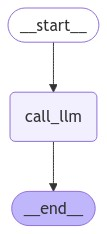

In [36]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [47]:
graph.invoke({"messages": [HumanMessage(content= "hi")]})

{'messages': [AIMessage(content='Hi there! How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-03a7bf69-3a1f-4f10-88c8-c09fe8cb7b3d-0', usage_metadata={'input_tokens': 99, 'output_tokens': 11, 'total_tokens': 110, 'input_token_details': {'cache_read': 0}})]}

In [48]:
graph.invoke({"messages": [HumanMessage(content= "deposit $5050 in rehan account his account number is 2344")]})

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_number": 2344.0, "amount": 5050.0, "name": "rehan"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-735d1f17-652a-4e66-919f-5eb9c07f18fc-0', tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_number': 2344.0, 'amount': 5050.0, 'name': 'rehan'}, 'id': 'e8ed926c-61b1-4208-afd3-ec8cfd8d9134', 'type': 'tool_call'}], usage_metadata={'input_tokens': 117, 'output_tokens': 12, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}})]}